In [1]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# If you need to determine the percent voxel change between two images follow these steps first. 

## If you already have a "percent.csv" file, skip to next section

In [2]:
affinefile = "/home/emilyjanedennis/Desktop/mouseann_to_rat_AFFINE.tif"
mouseratfile="/home/emilyjanedennis/Desktop/mouseann_to_rat.tif"

In [3]:
affine = tif.imread(affinefile)
mouserat = tif.imread(mouseratfile)

In [24]:
csvfilename="/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/PMA_ann.csv"
anns=pd.read_csv(csvfilename,usecols=[0,1],names=['id','abbr'])

In [25]:
df=anns

In [26]:
df.insert(2,'affine_vox',0)
df.insert(3,'mouserat_vox',0)

In [27]:
df

,id,abbr,affine_vox,mouserat_vox
0,1.0,TMv,0,0
1,2.0,SSp-m6b,0,0
2,4.0,IC,0,0
3,6.0,int,0,0
4,7.0,PSV,0,0
...,...,...,...,...
624,526322272.0,FRP6a,0,0
625,563807424.0,PoT,0,0
626,599626944.0,SCO,0,0
627,606826688.0,Pa4,0,0


In [28]:
for i in range(0,np.size(df['id'])-1):
    df.mouserat_vox[i] = np.size(mouserat[mouserat==df.id[i]])
    df.affine_vox[i] = np.size(affine[affine==df.id[i]])

<ipython-input-28-a1d2e4ee8e05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mouserat_vox[i] = np.size(mouserat[mouserat==df.id[i]])
<ipython-input-28-a1d2e4ee8e05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.affine_vox[i] = np.size(affine[affine==df.id[i]])


In [29]:
df.to_csv(r"/home/emilyjanedennis/Desktop/PMA_ann_mouserat_vox.csv")

In [30]:
df['change'] = df['affine_vox']-df['mouserat_vox']

In [33]:
df = df[df.mouserat_vox > 0]

In [34]:
dfpercent = df['change']/df['mouserat_vox']*100
dfpercent[np.isinf(dfpercent)]=0
df['percent'] = dfpercent
dfpercent.replace(0,np.nan)

<ipython-input-34-c65e6fae6b4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent'] = dfpercent


0      -0.676530
1       0.574614
2       3.643001
3      13.871764
4     -17.536925
         ...    
611     3.562054
612     5.143128
613     9.543468
614   -22.222222
615    -7.132460
Length: 614, dtype: float64

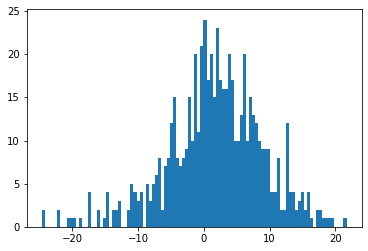

In [38]:
plt.hist(df.percent,bins=100)
plt.show()

In [39]:
mp = np.nanmedian(df.percent)
sp = np.nanstd(df.percent)

In [43]:
highmp = mp+sp
highmp

9.227998534211455

In [42]:
lowmp = mp-sp
lowmp

-5.347827327515767

In [44]:
df.to_csv(r"/home/emilyjanedennis/Desktop/percent.csv")

In [2]:
df=pd.read_csv("/home/emilyjanedennis/Desktop/percent.csv")

In [3]:
df

,Unnamed: 0,id,abbr,affine_vox,mouserat_vox,change,percent
0,0,1.0,TMv,36116,36362,-246,-0.676530
1,1,2.0,SSp-m6b,17503,17403,100,0.574614
2,2,4.0,IC,26686,25748,938,3.643001
3,3,6.0,int,276697,242990,33707,13.871764
4,4,7.0,PSV,141030,171022,-29992,-17.536925
...,...,...,...,...,...,...,...
609,611,10703.0,DG-mo,639534,617537,21997,3.562054
610,612,10704.0,DG-po,79852,75946,3906,5.143128
611,613,12345.0,PDTg,9022,8236,786,9.543468
612,614,12346.0,Pa5,14189,18243,-4054,-22.222222


In [47]:
too = df.id

In [48]:
mouserat_relative = mouserat

In [49]:
# add list of unique values not in twoxh/twoxl but in mouserat
x = np.unique(mouserat)
np.size(x)

57278

In [55]:
test = np.setdiff1d(x,too)
np.size(test)

56664

In [51]:
for i in test:
    mouserat_relative[mouserat_relative==i]=0

In [52]:
tif.imsave("/home/emilyjanedennis/Desktop/20200829_mouserat_zeros.tif",mouserat_relative)

In [53]:
for i in too:
    mouserat_relative[mouserat_relative==i]=df.loc[df['id']==i,'percent'].iloc[0]

In [54]:
tif.imsave("/home/emilyjanedennis/Desktop/mouserat_relative.tif",mouserat_relative)

# If you already have a percent file

In [2]:
df=pd.read_csv("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet//percent.csv")

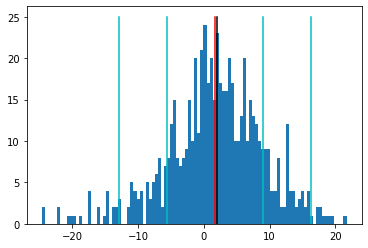

In [31]:
plt.hist(df.percent[df.affine_vox>5],bins=100)

dfmean = np.nanmean(df.percent[df.affine_vox>5])
dfmedian = np.nanmedian(df.percent[df.affine_vox>5])
dfstd = np.std(df.percent[df.affine_vox>5])
mp = dfmean + dfstd
mm = dfmean - dfstd

mp2 = dfmean + 2*dfstd
mp3 = dfmean + 3*dfstd
mm2 = dfmean - 2*dfstd
mm3 = dfmean - 3*dfstd


plt.plot([dfmean, dfmean],[0,25],'r')
plt.plot([dfmedian, dfmedian],[0,25],'k')
plt.plot([mp,mp],[0,25],'c')
plt.plot([mm,mm],[0,25],'c')
plt.plot([mp2,mp2],[0,25],'c')
plt.plot([mm2,mm2],[0,25],'c')
plt.show()

In [11]:
# want to make summary -- ideally show a ranked 3, 2, 1std>mean 
# in diff colors, and then the 
# values either written or in bar form on the right

df

,Unnamed: 0,id,abbr,affine_vox,mouserat_vox,change,percent
0,0,1.0,TMv,36116,36362,-246,-0.676530
1,1,2.0,SSp-m6b,17503,17403,100,0.574614
2,2,4.0,IC,26686,25748,938,3.643001
3,3,6.0,int,276697,242990,33707,13.871764
4,4,7.0,PSV,141030,171022,-29992,-17.536925
...,...,...,...,...,...,...,...
609,611,10703.0,DG-mo,639534,617537,21997,3.562054
610,612,10704.0,DG-po,79852,75946,3906,5.143128
611,613,12345.0,PDTg,9022,8236,786,9.543468
612,614,12346.0,Pa5,14189,18243,-4054,-22.222222


In [33]:
df2p = df[df.percent>mp2]
df2p = df2p.sort_values('percent',ascending=False)
df2m = df[df.percent < mm2]
df2m = df2m.sort_values('percent',ascending=False)

In [34]:
df2m

,Unnamed: 0,id,abbr,affine_vox,mouserat_vox,change,percent
441,443,852.0,PARN,396300,455051,-58751,-12.910861
464,466,903.0,ECU,49955,57490,-7535,-13.106627
103,103,198.0,pyd,20009,23032,-3023,-13.125217
544,546,1033.0,COPY,409406,474317,-64911,-13.685151
496,498,955.0,LRNm,98941,114657,-15716,-13.706969
225,227,445.0,SPVO,149057,174340,-25283,-14.502122
44,44,91.0,IP,131035,153562,-22527,-14.669645
601,603,1123.0,icp,75337,88414,-13077,-14.790644
79,79,153.0,V4r,41206,48386,-7180,-14.839003
56,56,114.0,SOCl,59534,70111,-10577,-15.086078


In [35]:
df2p

,Unnamed: 0,id,abbr,affine_vox,mouserat_vox,change,percent
501,503,962.0,MOs2/3,755537,620700,134837,21.723377
24,24,52.0,ENTl3,195678,163376,32302,19.771570
487,489,943.0,MOp2/3,697270,584826,112444,19.226915
71,71,139.0,ENTl5,222484,187518,34966,18.646743
390,392,767.0,MOs5,832331,704037,128294,18.222622
68,68,131.0,LA,177229,150647,26582,17.645224
11,11,20.0,ENTl2,255518,217263,38255,17.607692
490,492,946.0,PH,133688,113752,19936,17.525846
424,426,830.0,DMH,76786,65454,11332,17.312922


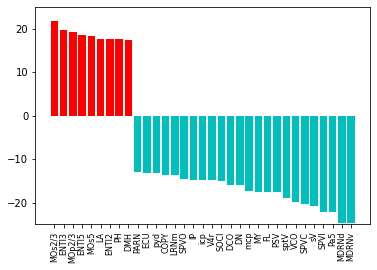

In [54]:
plt.bar(df2p.abbr,df2p.percent,color='r')
plt.bar(df2m.abbr,df2m.percent,color='c')
plt.xticks(rotation=90,fontsize=8)
plt.ylim([-25,25])
plt.show()